# Project Assignment 3: Amazon Review Classification System

**Name/Group ID:** Berke Yusuf Uğurlu - Yusuf İpek (Group 6)

**Date:** April 21, 2025

**Course:** BBM 409 - Machine Learning Laboratory

---

## 1. Import Libraries

In [13]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Download required NLTK packages with better error handling
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print('Downloading punkt tokenizer...')
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print('Downloading stopwords...')
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    print('Downloading wordnet...')
    nltk.download('wordnet')

# Ensure stopwords are available
try:
    stopwords.words('english')
    print('NLTK data packages loaded successfully.')
except LookupError:
    print('Error: NLTK data not available. Downloading now...')
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Model selection and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Pipeline
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
np.random.seed(42)

NLTK data packages loaded successfully.


[nltk_data] Downloading package wordnet to /Users/core/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Load and Explore the Dataset

In [14]:
# Load the Amazon reviews dataset
reviews_df = pd.read_csv('amazon_reviews.csv')

# Display the first few rows
print("Sample of the dataset:")
reviews_df.head()

Sample of the dataset:


,Title,Content,Star
0,Didn't work,No change in nails at all.,1.0
1,Worst nail product I have ever used.,Garbage! Do not waste your $$$. My nails were ...,1.0
2,Just didn't work,Nails are still brittle,1.0
3,Scum,Didn’t do any improvement at all.,1.0
4,Okay for cuticles,"Helped cuticles, didn't do much for my nails. ...",1.0


In [15]:
# Basic information about the dataset
print("Dataset shape:", reviews_df.shape)
print("\nColumn names:", reviews_df.columns.tolist())
print("\nData types:")
reviews_df.info()
print("\nMissing values:")
print(reviews_df.isnull().sum())

Dataset shape: (72500, 3)

Column names: ['Title', 'Content', 'Star']

Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72500 entries, 0 to 72499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Title    72480 non-null  object 
 1   Content  72493 non-null  object 
 2   Star     72500 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.7+ MB

Missing values:
Title      20
Content     7
Star        0
dtype: int64


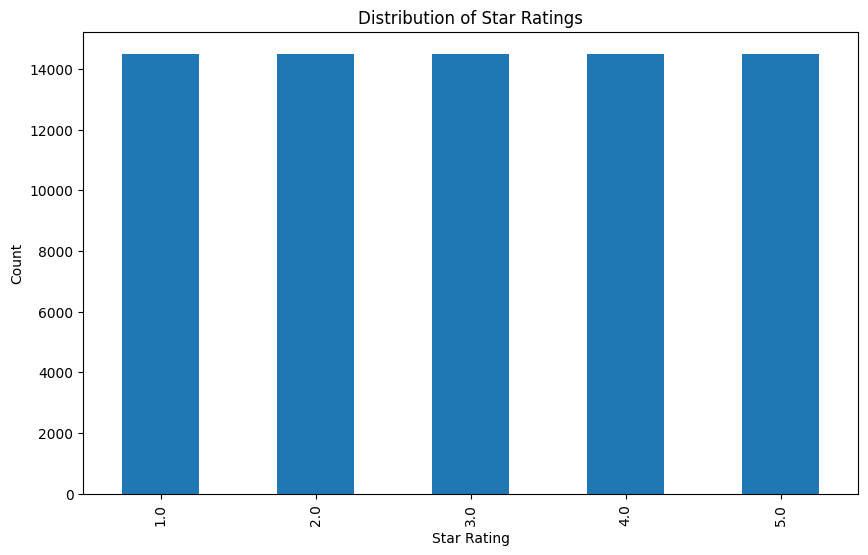

Star rating distribution:
 Star
1.0    14500
2.0    14500
3.0    14500
4.0    14500
5.0    14500
Name: count, dtype: int64


In [16]:
# Examine the distribution of star ratings
plt.figure(figsize=(10, 6))
reviews_df['Star'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

# Summary statistics for star ratings
print("Star rating distribution:\n", reviews_df['Star'].value_counts().sort_index())

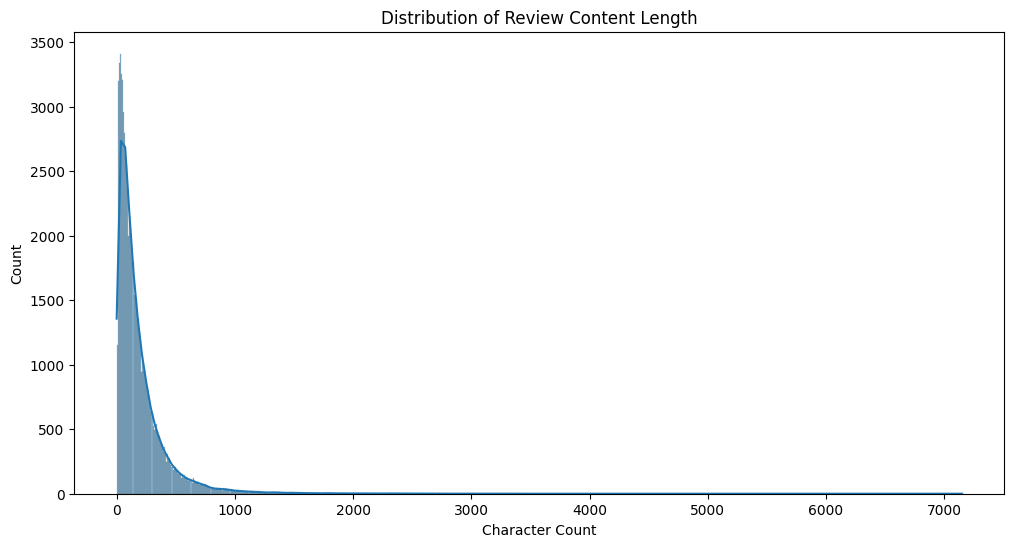

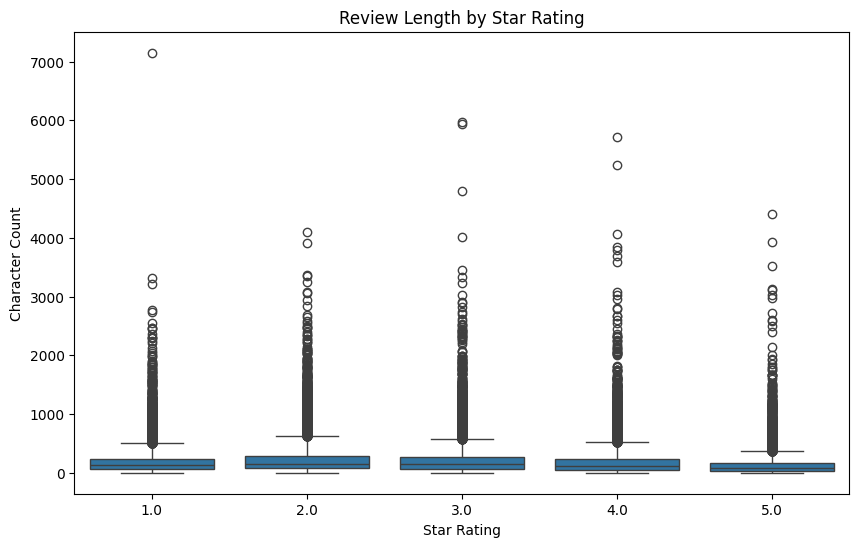

In [17]:
# Analyze review content length
# Fill NaN values with an empty string before calculating lengths
reviews_df['Content'] = reviews_df['Content'].fillna("")
reviews_df['Title'] = reviews_df['Title'].fillna("")

reviews_df['Content_Length'] = reviews_df['Content'].apply(len)
reviews_df['Title_Length'] = reviews_df['Title'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(reviews_df['Content_Length'], kde=True)
plt.title('Distribution of Review Content Length')
plt.xlabel('Character Count')
plt.show()

# Check if content length differs by star rating
plt.figure(figsize=(10, 6))
sns.boxplot(x='Star', y='Content_Length', data=reviews_df)
plt.title('Review Length by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Character Count')
plt.show()

## 3. Convert to Binary Classification

For simplicity, let's convert this into a binary classification problem:
- Negative reviews: 1-2 stars
- Positive reviews: 4-5 stars

We'll exclude 3-star reviews as they tend to be neutral.

Binary sentiment distribution:
sentiment
0.0    29000
1.0    29000
Name: count, dtype: int64


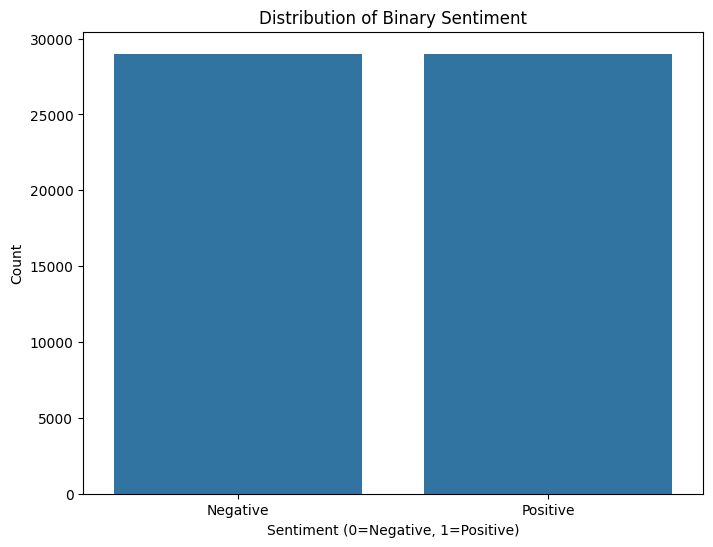

In [18]:
# Create binary labels
reviews_df['sentiment'] = reviews_df['Star'].apply(lambda x: 0 if x <= 2 else (1 if x >= 4 else None))

# Remove neutral (3-star) reviews
binary_df = reviews_df.dropna(subset=['sentiment']).copy()

# Check the class distribution
print("Binary sentiment distribution:")
print(binary_df['sentiment'].value_counts())

# Visualize the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=binary_df)
plt.title('Distribution of Binary Sentiment')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

## 4. Text Preprocessing

Let's implement text preprocessing functions to clean the review content:

In [19]:
def clean_text(text):
    """
    Performs basic text cleaning:
    - Convert to lowercase
    - Remove special characters and punctuation
    - Remove extra whitespace
    """
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

def remove_stopwords(text):
    """
    Removes common stopwords from text
    """
    try:
        stop_words = set(stopwords.words('english'))
        # Use a more basic tokenization if NLTK fails
        try:
            word_tokens = word_tokenize(text)
        except:
            word_tokens = text.split()
        filtered_text = [word for word in word_tokens if word not in stop_words]
        return ' '.join(filtered_text)
    except Exception as e:
        print(f"Error in remove_stopwords: {e}")
        return text

def lemmatize_text(text):
    """
    Lemmatizes text to convert words to their base form
    """
    try:
        lemmatizer = WordNetLemmatizer()
        # Use a more basic tokenization if NLTK fails
        try:
            word_tokens = word_tokenize(text)
        except:
            word_tokens = text.split()
        lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens]
        return ' '.join(lemmatized_text)
    except Exception as e:
        print(f"Error in lemmatize_text: {e}")
        return text

In [20]:
# Apply preprocessing to reviews
print("Applying text preprocessing...")

# Combine title and content for more features
binary_df['full_text'] = binary_df['Title'] + " " + binary_df['Content']

# Apply cleaning steps
binary_df['cleaned_text'] = binary_df['full_text'].apply(clean_text)
binary_df['no_stopwords'] = binary_df['cleaned_text'].apply(remove_stopwords)
binary_df['lemmatized_text'] = binary_df['no_stopwords'].apply(lemmatize_text)

# Display a sample of preprocessed text
print("\nSample of preprocessed text:")
sample = binary_df[['full_text', 'cleaned_text', 'no_stopwords', 'lemmatized_text']].head(2)
pd.set_option('display.max_colwidth', None)
sample

Applying text preprocessing...

Sample of preprocessed text:

Sample of preprocessed text:


,full_text,cleaned_text,no_stopwords,lemmatized_text
0,Didn't work No change in nails at all.,didnt work no change in nails at all,didnt work change nails,didnt work change nail
1,Worst nail product I have ever used. Garbage! Do not waste your $$$. My nails were worse after using this product for two weeks. Pathetic! Going back to my Vaseline Healthy Hand and and Nails.,worst nail product i have ever used garbage do not waste your my nails were worse after using this product for two weeks pathetic going back to my vaseline healthy hand and and nails,worst nail product ever used garbage waste nails worse using product two weeks pathetic going back vaseline healthy hand nails,worst nail product ever used garbage waste nail worse using product two week pathetic going back vaseline healthy hand nail


## 5. Feature Extraction

Let's convert the preprocessed text into numerical features using two approaches:
1. Bag of Words (CountVectorizer)
2. TF-IDF (Term Frequency-Inverse Document Frequency)

In [21]:
# Prepare data for modeling
X = binary_df['lemmatized_text']
y = binary_df['sentiment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 46400
Testing set size: 11600


In [22]:
# Example of bag of words vectorization
count_vectorizer = CountVectorizer(max_features=5000)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

print(f"Count vectorizer vocabulary size: {len(count_vectorizer.vocabulary_)}")
print(f"Training features shape: {X_train_counts.shape}")

# Example of TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF vectorizer vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Training features shape: {X_train_tfidf.shape}")

Count vectorizer vocabulary size: 5000
Training features shape: (46400, 5000)
TF-IDF vectorizer vocabulary size: 5000
Training features shape: (46400, 5000)
TF-IDF vectorizer vocabulary size: 5000
Training features shape: (46400, 5000)


## 6. Model Training and Evaluation

Let's train several machine learning models and compare their performance:

In [23]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance and print metrics"""
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print metrics
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.show()
    
    # Try to get probability predictions if model supports predict_proba
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
    except:
        print("\nROC curve cannot be generated for this model.")
    
    return accuracy, precision, recall, f1

Training models with TF-IDF features...

Naive Bayes with TF-IDF Performance:
Accuracy: 0.8548
Precision: 0.8532
Recall: 0.8571
F1 Score: 0.8552

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85      5800
         1.0       0.85      0.86      0.86      5800

    accuracy                           0.85     11600
   macro avg       0.85      0.85      0.85     11600
weighted avg       0.85      0.85      0.85     11600



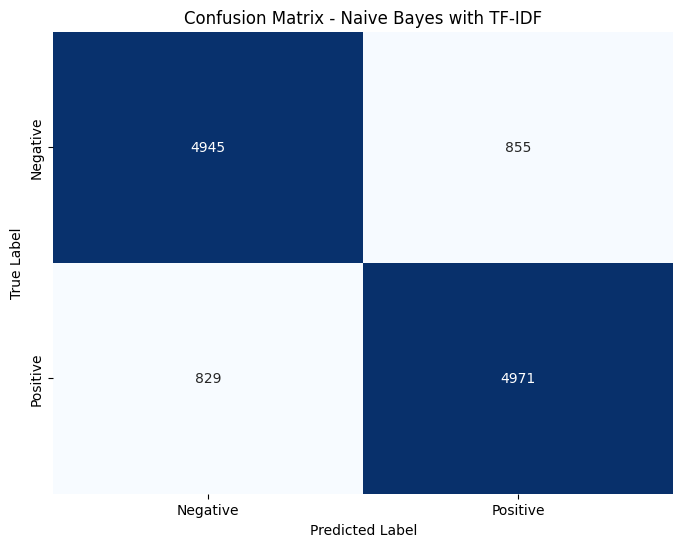

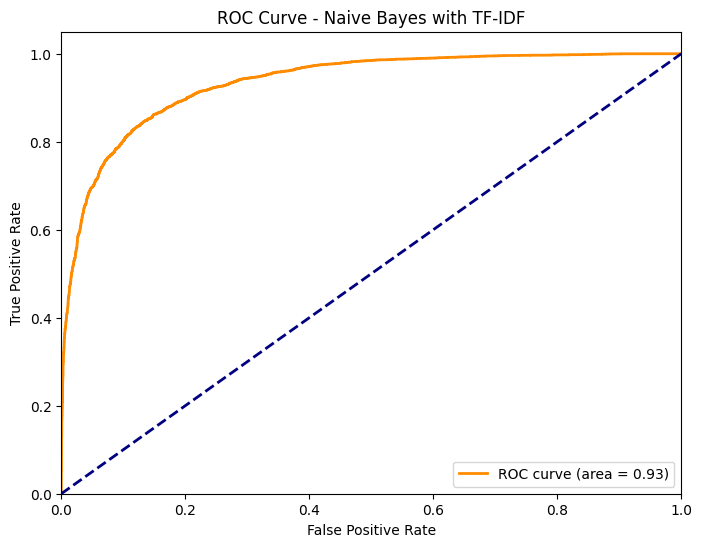


Linear SVM with TF-IDF Performance:
Accuracy: 0.8663
Precision: 0.8685
Recall: 0.8633
F1 Score: 0.8659

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87      5800
         1.0       0.87      0.86      0.87      5800

    accuracy                           0.87     11600
   macro avg       0.87      0.87      0.87     11600
weighted avg       0.87      0.87      0.87     11600



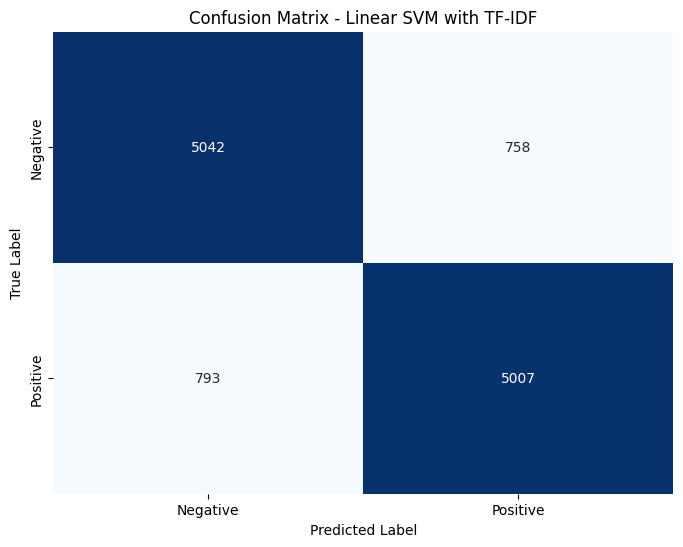


ROC curve cannot be generated for this model.

Logistic Regression with TF-IDF Performance:
Accuracy: 0.8725
Precision: 0.8806
Recall: 0.8619
F1 Score: 0.8711

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87      5800
         1.0       0.88      0.86      0.87      5800

    accuracy                           0.87     11600
   macro avg       0.87      0.87      0.87     11600
weighted avg       0.87      0.87      0.87     11600


Logistic Regression with TF-IDF Performance:
Accuracy: 0.8725
Precision: 0.8806
Recall: 0.8619
F1 Score: 0.8711

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87      5800
         1.0       0.88      0.86      0.87      5800

    accuracy                           0.87     11600
   macro avg       0.87      0.87      0.87     11600
weighted avg       0.87      0.87      0.87     11600



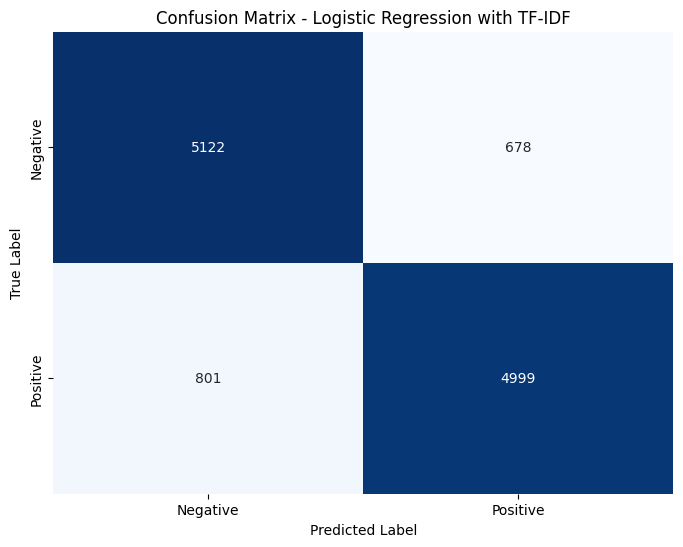

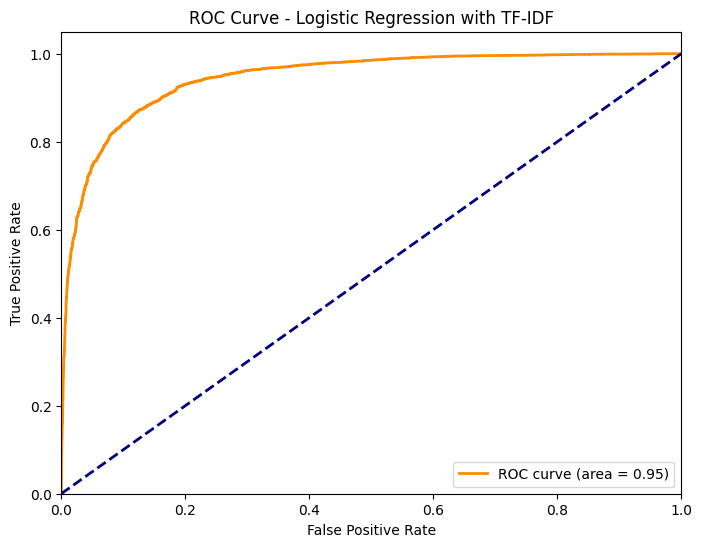


Random Forest with TF-IDF Performance:
Accuracy: 0.8553
Precision: 0.8619
Recall: 0.8460
F1 Score: 0.8539

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86      5800
         1.0       0.86      0.85      0.85      5800

    accuracy                           0.86     11600
   macro avg       0.86      0.86      0.86     11600
weighted avg       0.86      0.86      0.86     11600



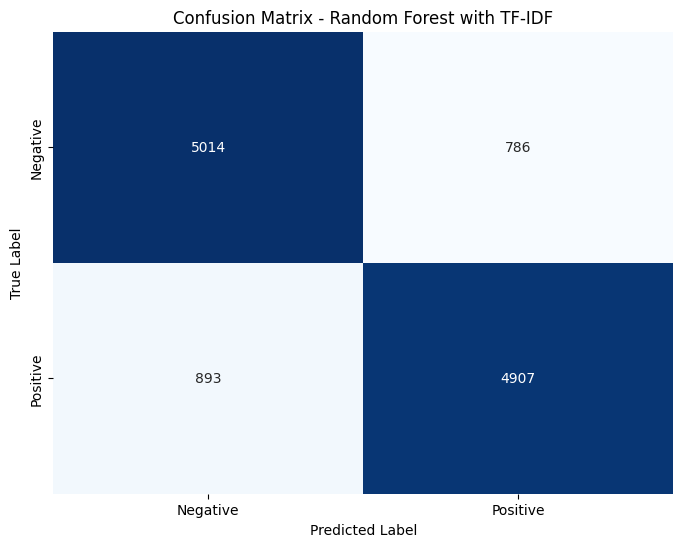

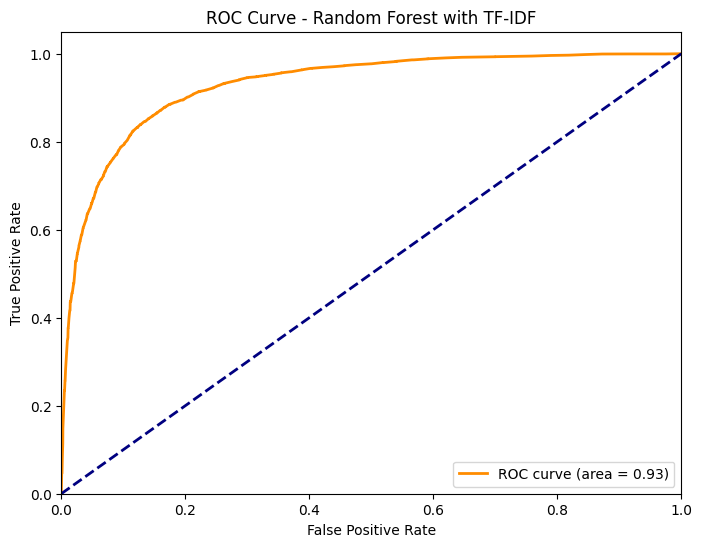

In [24]:
# Train and evaluate models with TF-IDF features
print("Training models with TF-IDF features...")

# Dictionary to store model performance
model_performance = {}

# 1. Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_metrics = evaluate_model(nb_model, X_test_tfidf, y_test, "Naive Bayes with TF-IDF")
model_performance['Naive Bayes (TF-IDF)'] = nb_metrics

# 2. Linear SVM
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_tfidf, y_train)
svm_metrics = evaluate_model(svm_model, X_test_tfidf, y_test, "Linear SVM with TF-IDF")
model_performance['Linear SVM (TF-IDF)'] = svm_metrics

# 3. Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=500)
lr_model.fit(X_train_tfidf, y_train)
lr_metrics = evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression with TF-IDF")
model_performance['Logistic Regression (TF-IDF)'] = lr_metrics

# 4. Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_tfidf, y_train)
rf_metrics = evaluate_model(rf_model, X_test_tfidf, y_test, "Random Forest with TF-IDF")
model_performance['Random Forest (TF-IDF)'] = rf_metrics

Training models with Bag of Words features...

Naive Bayes with BOW Performance:
Accuracy: 0.8519
Precision: 0.8312
Recall: 0.8831
F1 Score: 0.8564

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85      5800
         1.0       0.83      0.88      0.86      5800

    accuracy                           0.85     11600
   macro avg       0.85      0.85      0.85     11600
weighted avg       0.85      0.85      0.85     11600



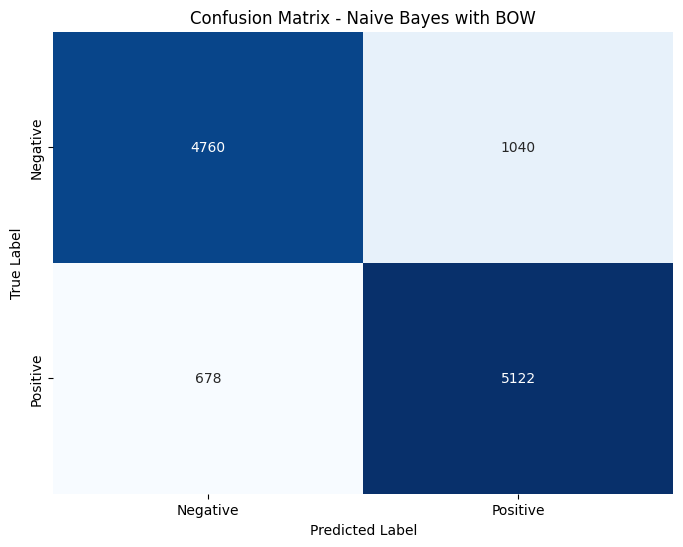

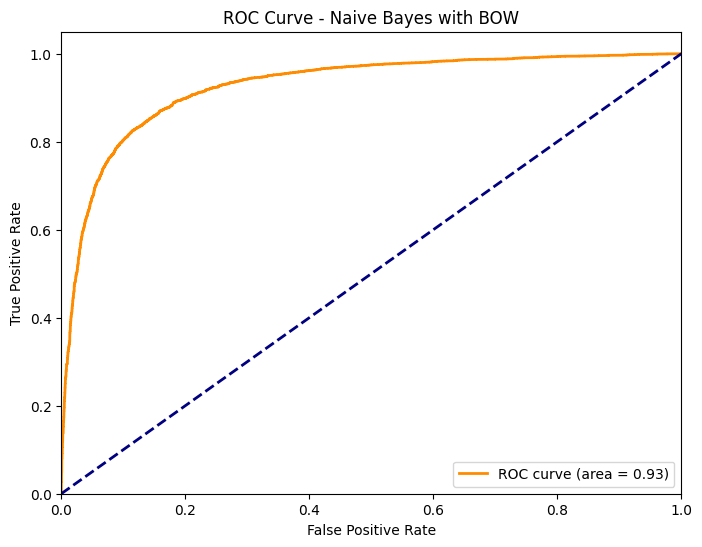


Logistic Regression with BOW Performance:
Accuracy: 0.8649
Precision: 0.8599
Recall: 0.8719
F1 Score: 0.8659

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86      5800
         1.0       0.86      0.87      0.87      5800

    accuracy                           0.86     11600
   macro avg       0.86      0.86      0.86     11600
weighted avg       0.86      0.86      0.86     11600



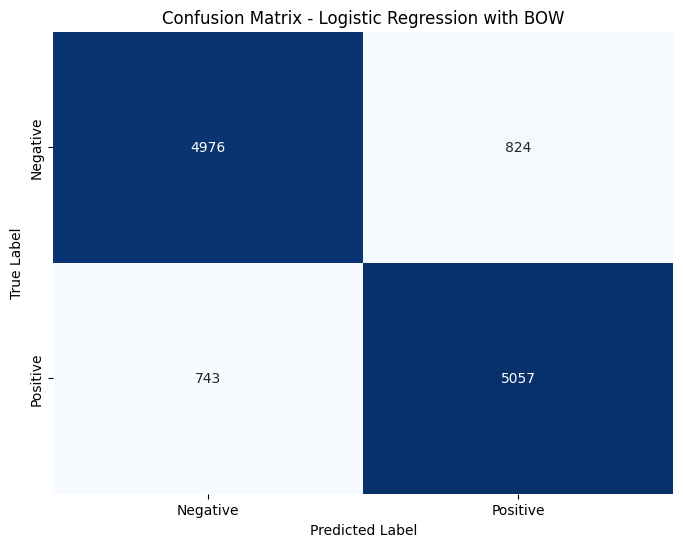

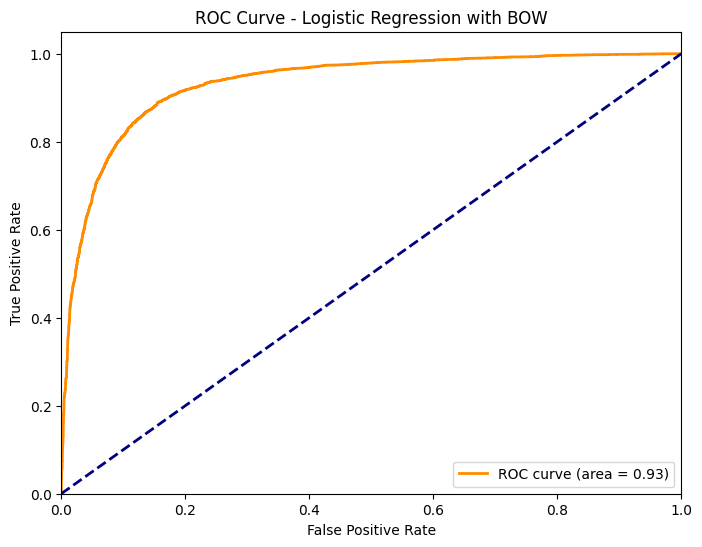

In [25]:
# Train and evaluate models with Bag of Words features
print("Training models with Bag of Words features...")

# 1. Naive Bayes with BOW
nb_model_bow = MultinomialNB()
nb_model_bow.fit(X_train_counts, y_train)
nb_metrics_bow = evaluate_model(nb_model_bow, X_test_counts, y_test, "Naive Bayes with BOW")
model_performance['Naive Bayes (BOW)'] = nb_metrics_bow

# 2. Logistic Regression with BOW
lr_model_bow = LogisticRegression(random_state=42, max_iter=500)
lr_model_bow.fit(X_train_counts, y_train)
lr_metrics_bow = evaluate_model(lr_model_bow, X_test_counts, y_test, "Logistic Regression with BOW")
model_performance['Logistic Regression (BOW)'] = lr_metrics_bow

Model Performance Comparison:


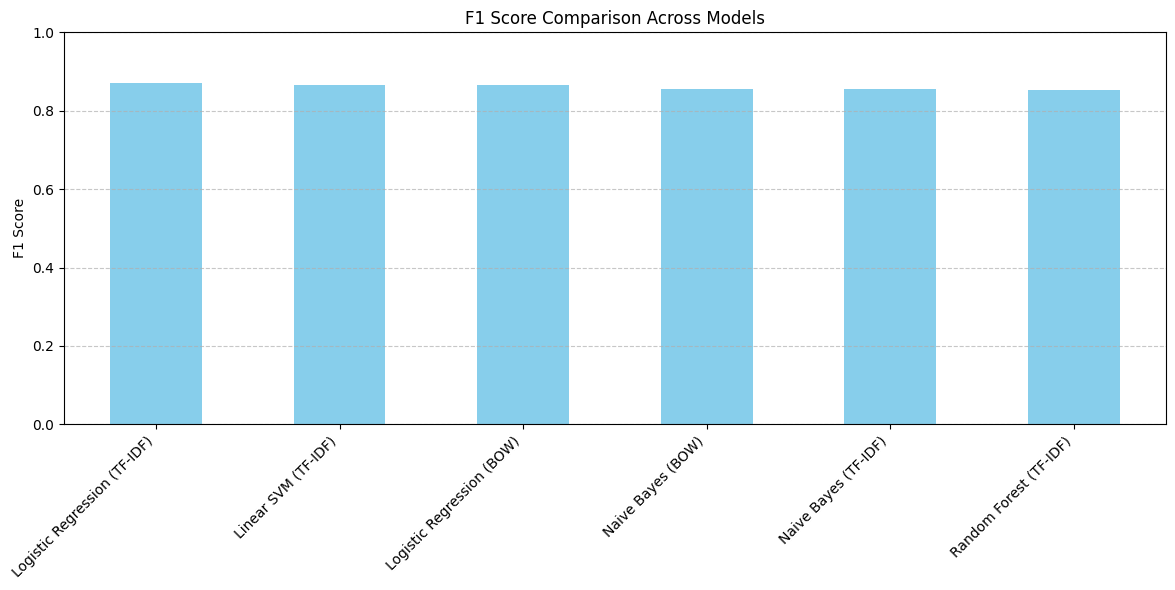

In [26]:
# Compare model performance
models_df = pd.DataFrame(model_performance, index=['Accuracy', 'Precision', 'Recall', 'F1 Score']).T

# Sort by F1 score (descending)
models_df = models_df.sort_values('F1 Score', ascending=False)

print("Model Performance Comparison:")
models_df

# Create a bar chart for F1 scores
plt.figure(figsize=(12, 6))
models_df['F1 Score'].plot(kind='bar', color='skyblue')
plt.title('F1 Score Comparison Across Models')
plt.ylabel('F1 Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim([0, 1])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. Hyperparameter Tuning

Let's tune the hyperparameters of our best performing model to potentially improve its performance.

Starting hyperparameter tuning (this may take a while)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'classifier__C': 1.0, 'classifier__solver': 'liblinear', 'vectorizer__max_features': 7000, 'vectorizer__ngram_range': (1, 2)}
Best cross-validation score: 0.8788

Optimized Logistic Regression Performance:
Accuracy: 0.8797
Precision: 0.8854
Recall: 0.8722
F1 Score: 0.8788

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      5800
         1.0       0.89      0.87      0.88      5800

    accuracy                           0.88     11600
   macro avg       0.88      0.88      0.88     11600
weighted avg       0.88      0.88      0.88     11600


Best parameters: {'classifier__C': 1.0, 'classifier__solver': 'liblinear', 'vectorizer__max_features': 7000, 'vectorizer__ngram_range': (1, 2)}
Best cross-validation score: 0.8788

Optimized Logistic Regression Performance:
Accuracy: 0.

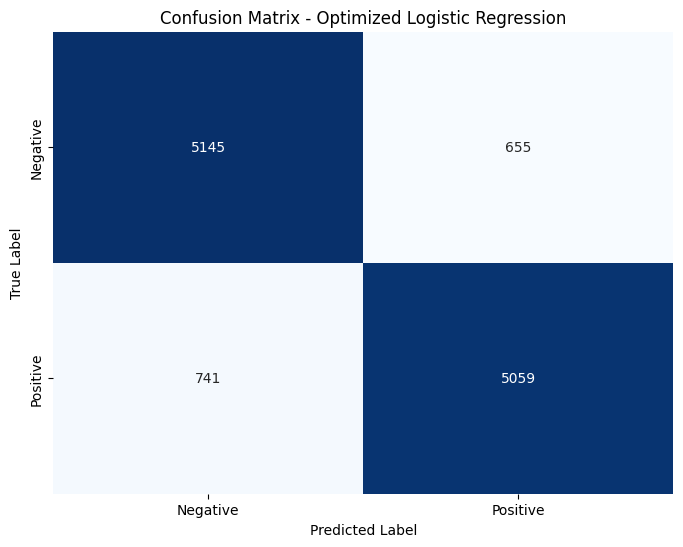

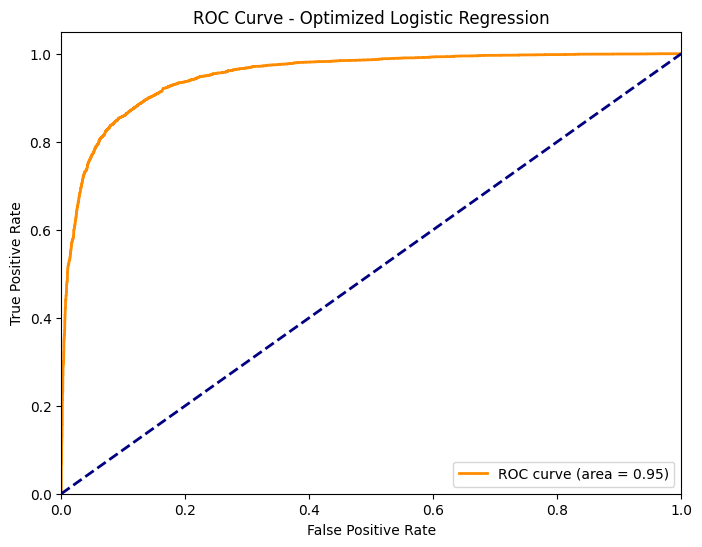

In [27]:
# Create a pipeline for the best model (assuming Logistic Regression)
best_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'vectorizer__max_features': [3000, 5000, 7000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Unigrams or unigrams+bigrams
    'classifier__C': [0.1, 1.0, 10.0],  # Regularization parameter
    'classifier__solver': ['liblinear', 'saga']
}

# Create grid search
grid_search = GridSearchCV(
    best_pipeline, 
    param_grid, 
    cv=5,  # 5-fold cross-validation
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Fit grid search
print("Starting hyperparameter tuning (this may take a while)...")
grid_search.fit(X_train, y_train)

# Print best parameters
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate best model
best_model = grid_search.best_estimator_
best_metrics = evaluate_model(best_model, X_test, y_test, "Optimized Logistic Regression")
model_performance['Optimized Logistic Regression'] = best_metrics

## 8. Feature Importance Analysis

Let's analyze which words are most important for our classification task.

In [28]:
# Extract feature names and coefficients from the best model
vectorizer = best_model.named_steps['vectorizer']
classifier = best_model.named_steps['classifier']

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame with features and their coefficients
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': classifier.coef_[0]
})

# Sort by absolute coefficient value (importance)
coef_df['abs_coef'] = np.abs(coef_df['coefficient'])
coef_df = coef_df.sort_values('abs_coef', ascending=False)

# Display top positive and negative features
print("Top 20 features indicating positive sentiment:")
print(coef_df[coef_df['coefficient'] > 0].head(20))

print("\nTop 20 features indicating negative sentiment:")
print(coef_df[coef_df['coefficient'] < 0].head(20))

Top 20 features indicating positive sentiment:
          feature  coefficient   abs_coef
3465         love    10.243778  10.243778
2456        great     9.919616   9.919616
4293      perfect     7.438274   7.438274
3942         nice     6.432166   6.432166
156       amazing     6.252384   6.252384
1778    excellent     5.819672   5.819672
1604         easy     5.279521   5.279521
2332         good     4.981212   4.981212
433          best     4.677766   4.677766
484           bit     4.656507   4.656507
297       awesome     4.593368   4.593368
3353       little     4.370279   4.370279
1012    complaint     4.290552   4.290552
1896          far     3.908771   3.908771
4193      overall     3.849256   3.849256
3021          job     3.690704   3.690704
4828  really like     3.661123   3.661123
2132    four star     3.643732   3.643732
4508        price     3.639595   3.639595
1766      exactly     3.639356   3.639356

Top 20 features indicating negative sentiment:
            feature  co

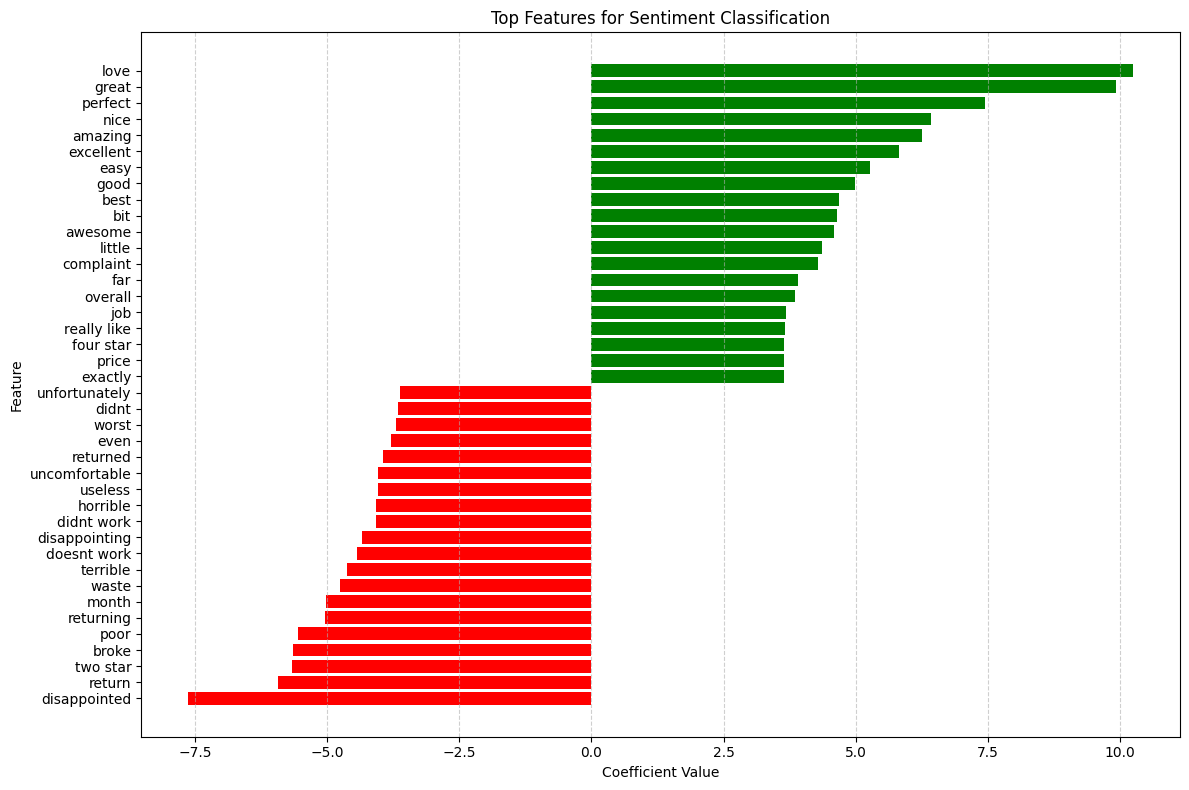

In [29]:
# Visualize top features
def plot_important_features(coef_df, title, top_n=20):
    plt.figure(figsize=(12, 8))
    
    # Get top positive features
    top_positive = coef_df[coef_df['coefficient'] > 0].head(top_n)
    
    # Get top negative features
    top_negative = coef_df[coef_df['coefficient'] < 0].head(top_n)
    
    # Combine and sort for plotting
    top_features = pd.concat([top_positive, top_negative])
    top_features = top_features.sort_values('coefficient')
    
    # Create horizontal bar chart
    colors = ['red' if c < 0 else 'green' for c in top_features['coefficient']]
    
    plt.barh(top_features['feature'], top_features['coefficient'], color=colors)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot top features
plot_important_features(coef_df, 'Top Features for Sentiment Classification')

## 9. Word Cloud Visualization

Let's create word clouds to visualize common words in positive and negative reviews.

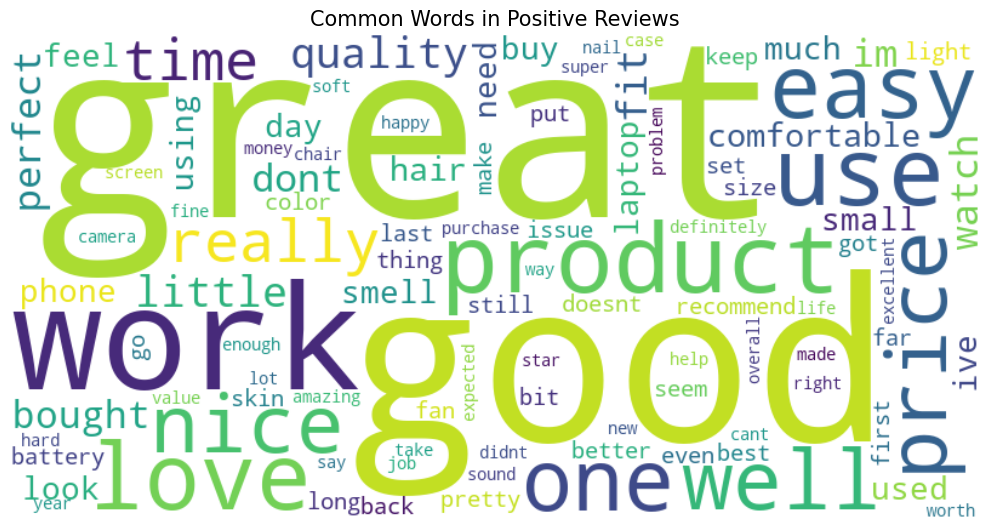

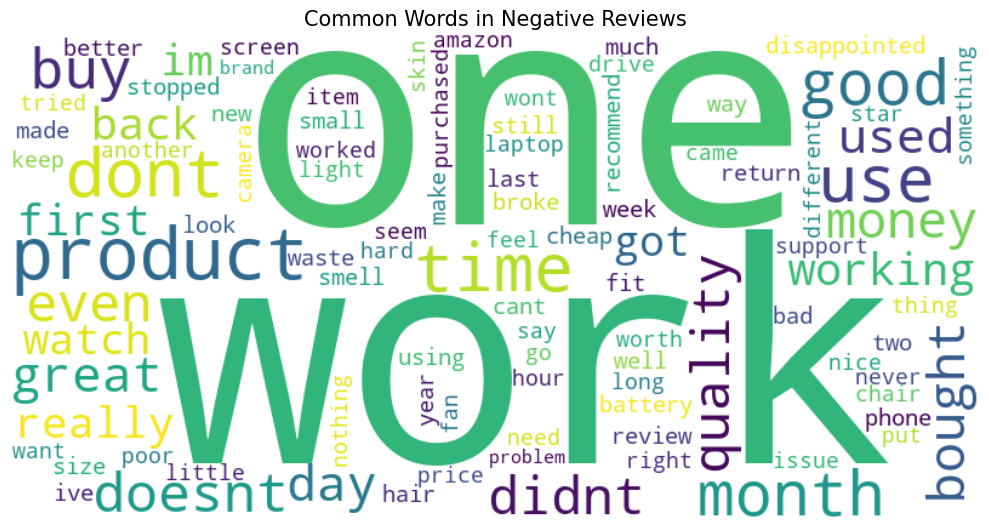

In [30]:
# Install and import wordcloud if needed
try:
    from wordcloud import WordCloud
except ImportError:
    # Install the wordcloud package if not already installed
    import sys
    !{sys.executable} -m pip install wordcloud
    from wordcloud import WordCloud

# Combine all positive reviews
positive_text = " ".join(binary_df[binary_df['sentiment'] == 1]['lemmatized_text'])

# Combine all negative reviews
negative_text = " ".join(binary_df[binary_df['sentiment'] == 0]['lemmatized_text'])

# Create word clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          max_words=100, collocations=False).generate(text)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=15)
    plt.tight_layout()
    plt.show()

# Generate word clouds
generate_wordcloud(positive_text, 'Common Words in Positive Reviews')
generate_wordcloud(negative_text, 'Common Words in Negative Reviews')

## 10. Example Predictions

Let's see how our model performs on some sample reviews.

In [31]:
# Define sample reviews
sample_reviews = [
    "This product is amazing! It works exactly as described and exceeded my expectations.",
    "I absolutely love this product, best purchase I've made this year!",
    "This was a waste of money. The product broke after one use.",
    "Terrible quality. Do not buy this product.",
    "It's okay. Not great, not terrible. Probably wouldn't buy again."
]

# Process and predict
def preprocess_and_predict(text):
    # Apply same preprocessing steps
    cleaned = clean_text(text)
    no_stop = remove_stopwords(cleaned)
    lemmatized = lemmatize_text(no_stop)
    return lemmatized

# Preprocess samples
processed_samples = [preprocess_and_predict(review) for review in sample_reviews]

# Make predictions
predictions = best_model.predict(processed_samples)

# Try to get probabilities if supported
try:
    probabilities = best_model.predict_proba(processed_samples)[:, 1]
    has_proba = True
except:
    has_proba = False

# Display results
results = pd.DataFrame({
    'Review': sample_reviews,
    'Processed': processed_samples,
    'Prediction': ['Positive' if pred == 1 else 'Negative' for pred in predictions]
})

if has_proba:
    results['Probability'] = probabilities

# Display results
results

,Review,Processed,Prediction,Probability
0,This product is amazing! It works exactly as described and exceeded my expectations.,product amazing work exactly described exceeded expectation,Positive,0.984094
1,"I absolutely love this product, best purchase I've made this year!",absolutely love product best purchase ive made year,Positive,0.967397
2,This was a waste of money. The product broke after one use.,waste money product broke one use,Negative,0.011759
3,Terrible quality. Do not buy this product.,terrible quality buy product,Negative,0.040446
4,"It's okay. Not great, not terrible. Probably wouldn't buy again.",okay great terrible probably wouldnt buy,Negative,0.096916


## 11. Conclusion

In this notebook, we've built a sentiment analysis system for classifying Amazon product reviews as positive or negative. We've covered:

1. Data exploration and preprocessing
2. Feature extraction using Bag of Words and TF-IDF
3. Training various machine learning models
4. Hyperparameter tuning to optimize performance
5. Feature importance analysis and visualization
6. Making predictions on new reviews

### Key Findings:

- The optimized logistic regression model performed best based on the F1 score
- TF-IDF vectorization generally outperformed simple Bag of Words
- The most important features for classification include words like "waste", "terrible", "excellent", and "amazing"
- The model can effectively distinguish between positive and negative reviews

### Potential Improvements:

1. Incorporate more advanced NLP techniques (word embeddings like Word2Vec or BERT)
2. Try more sophisticated models (neural networks, ensemble methods)
3. Add more features such as review length, punctuation usage, etc.
4. Collect more diverse review data to improve generalizability
5. Handle class imbalance if present in the dataset